In [1]:
%reset

import keras
import pickle as pk
import matplotlib.pyplot as pl
import matplotlib
import numpy as np
import pdb

%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# The neural network architecture that we'll use in the example below is based on:

See https://github.com/eriklindernoren/Keras-GAN/blob/master/context_encoder/context_encoder.py

## Data location and dimensions

In [2]:
#The data are "cutouts" from full-sky maps made from observations by the Planck satellite.
#These maps were constructed at an observing frequency of 857 GHz
data_dir = './cutout_data/'
# this file contains some cutouts that are "off star", i.e. centered at random locations on the sky
# and not on star locations
offstar_file = 'cutouts_1000offstarfirstpass_01.pk'
#The iniital cutouts have a dimension of 200x200.  We'll reduce the dimension to dim_reduced x dim_reduced
#to speed up the analysis
dim_reduced = 32 
#We're going to mask out a small part of the center of the cutout with dimension dim_mask x dim_mask
dim_mask = 8

## Load the cutout data

In [3]:
#load the data
cutout_data = pk.load(open(data_dir + offstar_file, 'rb'))
print(cutout_data.keys())
ll = cutout_data['l'] # galatic longitude of the cutout
bb = cutout_data['b'] # galactic latitude of the cutout
cutouts_orig = cutout_data['cutouts']
print(cutouts_orig.shape)

dict_keys(['cutouts', 'l', 'b'])
(1000, 200, 200)


## Plot a few cutouts

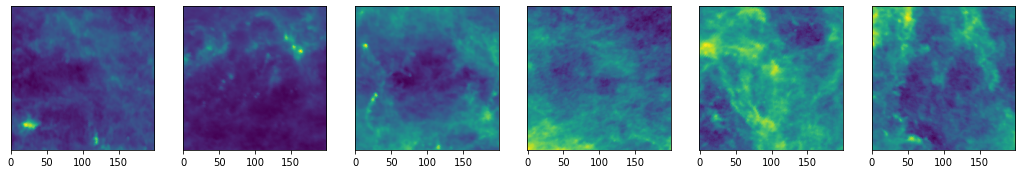

In [4]:
nplots = 6
fig, ax = pl.subplots(1,nplots, figsize = (nplots*3., 4))
for ii in range(0,nplots):
    ax[ii].imshow(np.log(cutouts_orig[ii,:,:]))
    #ax[ii].xaxis.set_visible(False)
    ax[ii].yaxis.set_visible(False)

## Reduce the dimensionality of the cutouts

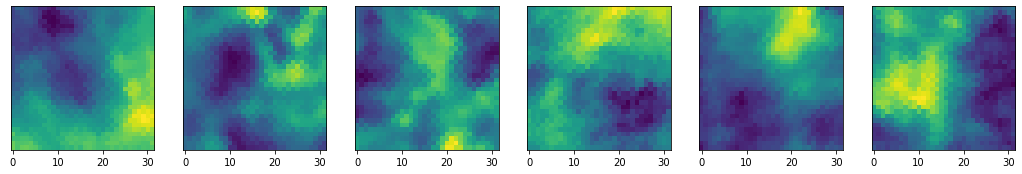

In [5]:
orig_dims = cutouts_orig.shape
min_ind = int(orig_dims[1]/2 - dim_reduced/2)
max_ind = int(orig_dims[1]/2 + dim_reduced/2)
cutouts = cutouts_orig[:, min_ind:max_ind, min_ind:max_ind]

nplots = 6
fig, ax = pl.subplots(1,nplots, figsize = (nplots*3., 4))
for ii in range(0,nplots):
    ax[ii].imshow(np.log(cutouts[ii,:,:]))
    #ax[ii].xaxis.set_visible(False)
    ax[ii].yaxis.set_visible(False)
    
#fig.savefig('./network_out/example_images.png')

## Set up the neural network

In [6]:
from __future__ import print_function, division

from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

class ContextEncoder():
    def __init__(self):
        self.img_rows = dim_reduced
        self.img_cols = dim_reduced
        self.mask_height = dim_mask
        self.mask_width = dim_mask
        #777777777777
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.missing_shape = (self.mask_height, self.mask_width, self.channels)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates the missing
        # part of the image
        masked_img = Input(shape=self.img_shape)
        gen_missing = self.generator(masked_img)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines
        # if it is generated or if it is a real image
        valid = self.discriminator(gen_missing)

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model(masked_img , [gen_missing, valid])
        self.combined.compile(loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.999, 0.001],
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        # Encoder
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(512, kernel_size=1, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))

        # Decoder
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation('tanh'))

        model.summary()

        masked_img = Input(shape=self.img_shape)
        gen_missing = model(masked_img)

        return Model(masked_img, gen_missing)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.missing_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.missing_shape)
        validity = model(img)

        return Model(img, validity)

    def mask_randomly(self, imgs):
        y1 = np.random.randint(0, self.img_rows - self.mask_height, imgs.shape[0])
        y2 = y1 + self.mask_height
        x1 = np.random.randint(0, self.img_rows - self.mask_width, imgs.shape[0])
        x2 = x1 + self.mask_width

        masked_imgs = np.empty_like(imgs)
        missing_parts = np.empty((imgs.shape[0], self.mask_height, self.mask_width, self.channels))
        for i, img in enumerate(imgs):
            masked_img = img.copy()
            _y1, _y2, _x1, _x2 = y1[i], y2[i], x1[i], x2[i]
            missing_parts[i] = masked_img[_y1:_y2, _x1:_x2, :].copy()
            masked_img[_y1:_y2, _x1:_x2, :] = 0
            masked_imgs[i] = masked_img

        return masked_imgs, missing_parts, (y1, y2, x1, x2)

    def mask_center(self, imgs):
        y1 = int(self.img_rows/2) - int(self.mask_height/2)
        y2 = y1 + self.mask_height
        x1 = int(self.img_rows/2) - int(self.mask_width/2)
        x2 = x1 + self.mask_width

        masked_imgs = np.empty_like(imgs)
        missing_parts = np.empty((imgs.shape[0], self.mask_height, self.mask_width, self.channels))
        for i, img in enumerate(imgs):
            masked_img = img.copy()
            missing_parts[i] = masked_img[y1:y2, x1:x2, :].copy()
            masked_img[y1:y2, x1:x2, :] = -100
            masked_imgs[i] = masked_img

        return masked_imgs, missing_parts, (y1, y2, x1, x2)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        #(X_train, y_train), (_, _) = cifar10.load_data()
        #pdb.set_trace()
        X_train = np.expand_dims(np.log(cutouts),axis=3)
        
        
        # Rescale -1 to 1
        #77777777777
        X_mean = np.mean(X_train)
        X_std = np.std(X_train)
        X_train = (X_train - X_mean)/X_std
        #y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            masked_imgs, missing_parts, _ = self.mask_center(imgs)

            # Generate a batch of new images
            gen_missing = self.generator.predict(masked_imgs)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(missing_parts, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_missing, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(masked_imgs, [missing_parts, valid])

            # Plot the progress
            print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                idx = np.random.randint(0, X_train.shape[0], 6)
                imgs = X_train[idx]
                self.sample_images(epoch, imgs)

    def sample_images(self, epoch, imgs):
        r, c = 3, 6

        masked_imgs, missing_parts, (y1, y2, x1, x2) = self.mask_center(imgs)
        gen_missing = self.generator.predict(masked_imgs)

        imgs = 0.5 * imgs + 0.5
        masked_imgs = 0.5 * masked_imgs + 0.5
        gen_missing = 0.5 * gen_missing + 0.5

        fig, axs = plt.subplots(r, c)
        for i in range(c):
            axs[0,i].imshow(imgs[i, :,:], vmin = 0., vmax = 1.0)
            axs[0,i].axis('off')
            axs[1,i].imshow(masked_imgs[i, :,:], vmin = 0., vmax = 1.0)
            axs[1,i].axis('off')
            filled_in = imgs[i].copy()
            filled_in[y1:y2, x1:x2, :] = gen_missing[i]
            axs[2,i].imshow(filled_in, vmin = 0., vmax = 1.0)
            axs[2,i].axis('off')
        fig.savefig("network_output/images/%d.png" % epoch)
        plt.close()
        
    def save_model(self):

        def save(model, model_name):
            model_path = "network_output/saved_model/%s.json" % model_name
            weights_path = "network_output/saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")




In [7]:
context_encoder = ContextEncoder()
context_encoder.train(epochs=200, batch_size=64, sample_interval=100)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 4, 4, 64)          640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4, 4, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 64)          256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2, 2, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 128)         512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 256)         2

46 [D loss: 0.518463, acc: 78.91%] [G loss: 0.169743, mse: 0.169359]
47 [D loss: 0.435694, acc: 79.69%] [G loss: 0.347845, mse: 0.347532]
48 [D loss: 0.428328, acc: 78.91%] [G loss: 0.232739, mse: 0.232127]
49 [D loss: 0.505081, acc: 76.56%] [G loss: 0.123803, mse: 0.123188]
50 [D loss: 0.666215, acc: 64.06%] [G loss: 0.153112, mse: 0.152807]
51 [D loss: 0.392595, acc: 82.81%] [G loss: 0.221768, mse: 0.221283]
52 [D loss: 0.411320, acc: 95.31%] [G loss: 0.237322, mse: 0.236862]
53 [D loss: 0.599822, acc: 75.00%] [G loss: 0.138479, mse: 0.138033]
54 [D loss: 0.800930, acc: 66.41%] [G loss: 0.182539, mse: 0.182153]
55 [D loss: 0.461179, acc: 89.84%] [G loss: 0.513079, mse: 0.512617]
56 [D loss: 0.480550, acc: 80.47%] [G loss: 0.219792, mse: 0.219548]
57 [D loss: 0.362646, acc: 94.53%] [G loss: 0.215378, mse: 0.214739]
58 [D loss: 0.402065, acc: 79.69%] [G loss: 0.111538, mse: 0.110891]
59 [D loss: 0.423344, acc: 88.28%] [G loss: 0.829326, mse: 0.829496]
60 [D loss: 0.442592, acc: 95.31%]

164 [D loss: 0.105308, acc: 99.22%] [G loss: 0.442829, mse: 0.441853]
165 [D loss: 0.147091, acc: 99.22%] [G loss: 0.157569, mse: 0.156365]
166 [D loss: 0.115053, acc: 100.00%] [G loss: 0.307758, mse: 0.306760]
167 [D loss: 0.076501, acc: 99.22%] [G loss: 0.506926, mse: 0.506248]
168 [D loss: 0.204402, acc: 99.22%] [G loss: 0.145515, mse: 0.144448]
169 [D loss: 0.121143, acc: 100.00%] [G loss: 0.361221, mse: 0.360747]
170 [D loss: 0.200660, acc: 96.88%] [G loss: 0.131581, mse: 0.130789]
171 [D loss: 0.119526, acc: 98.44%] [G loss: 0.121858, mse: 0.120721]
172 [D loss: 0.108684, acc: 100.00%] [G loss: 0.461398, mse: 0.460655]
173 [D loss: 0.090594, acc: 100.00%] [G loss: 0.181078, mse: 0.179828]
174 [D loss: 0.114057, acc: 100.00%] [G loss: 0.403841, mse: 0.402933]
175 [D loss: 0.074787, acc: 100.00%] [G loss: 0.535792, mse: 0.534723]
176 [D loss: 0.085264, acc: 100.00%] [G loss: 0.315941, mse: 0.314916]
177 [D loss: 0.053679, acc: 100.00%] [G loss: 0.545243, mse: 0.544544]
178 [D loss:

In [ ]:
#-try rotating, flipping, etc.
#-multi-frequency?